In [12]:
import pandas as pd
import numpy as np
from helper_functions import resize
import dlib
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils import face_utils
import random
from math import pi
import os
import math

# Constants

In [2]:
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]
data_path = '../dataset/'
model_path = '../models/'

In [9]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

# Importing Data

In [17]:
data = []
for mood in moods:
    for filename in os.listdir(data_path + 'ck/' + mood):
        data.append([filename, mood])
df = pd.DataFrame(data, columns=['filename','emotion'])
df.set_index('filename', inplace=True)
df["pixels"] = ['']*df.shape[0]
print(df.shape)
display(df.sample(10))

(902, 2)


,emotion,pixels
filename,,
S102_005_00000001.png,neutral,
S042_002_00000001.png,neutral,
S054_001_00000001.png,neutral,
S119_006_00000001.png,neutral,
S096_004_00000001.png,neutral,
S070_005_00000001.png,neutral,
S079_001_00000001.png,neutral,
S073_004_00000001.png,neutral,
S088_004_00000020.png,disgust,


# Feature Extraction

Processed: 100, 200, 300, 400, 500, 600, 700, 800, 900.

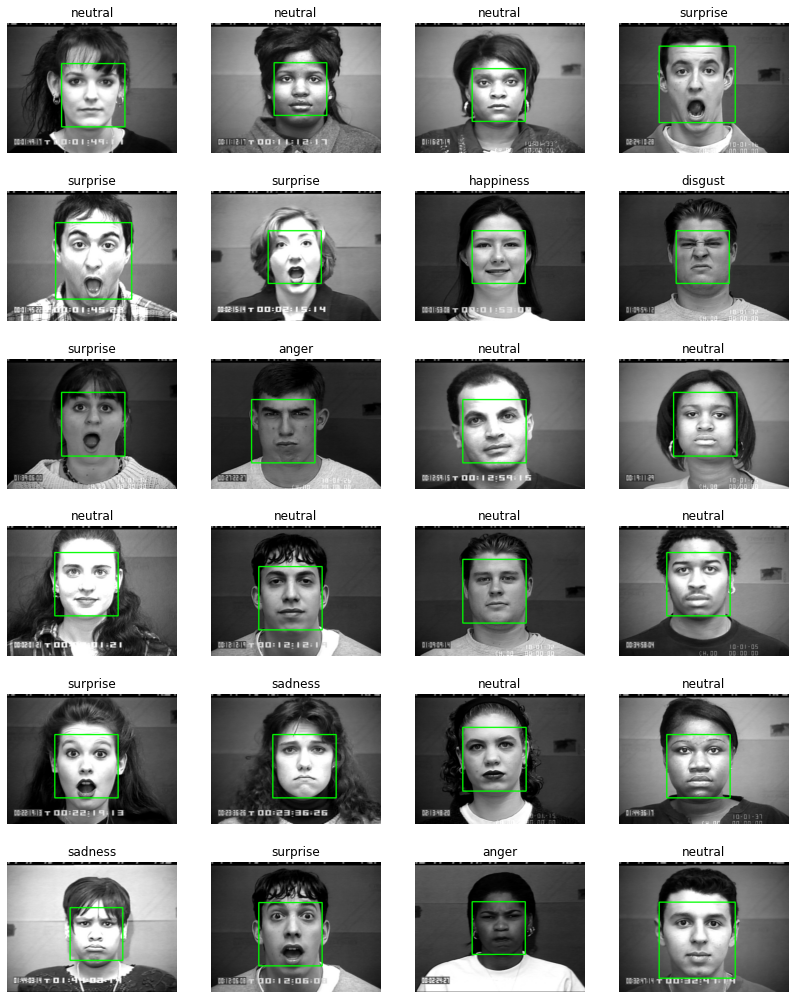

CPU times: total: 46.3 s
Wall time: 44.1 s


In [40]:
%%time
rand = random.sample(range(df.shape[0]), 24)
fig = plt.figure(figsize=(14, 18))
i = 0

print('Processed: ', end='')
for filename, row in df.iterrows():
    i += 1
    if not i % 100:
        print(i, end='.' if i==df.shape[0]//100*100 else ', ')    
        
    vectors, coords = [], []
        
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread('%sck/%s/%s' % (data_path, row['emotion'], filename))
    image = imutils.resize(image, width=400)

    # detect faces & facial landmarks
    rect = detector(image, 0)[0]
    shape = predictor(image, rect)
    shape = face_utils.shape_to_np(shape)

    # draw bounding box
    (x,y,w,h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
                        
    # show
    if i in rand:        
        fig.add_subplot(6, 4, rand.index(i)+1)
        plt.title(row['emotion'])
        plt.axis("off")
        plt.imshow(image)
            
    # store inputs in dataset
    dim = 48
    crop = image[y:y+h, x:x+w]
    crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
    crop = cv2.equalizeHist(crop)
    crop = resize(crop, dim)
    crop = crop.reshape(-1)
    if len(crop) == dim*dim:
        df.loc[filename, 'pixels'] = ' '.join(str(e) for e in crop)
        
plt.show()

# Filter Data

In [41]:
df = df[df['pixels'] != '']
print(df.shape[0])
display(df.head())

902


,emotion,pixels
filename,,
S010_004_00000019.png,anger,203 157 152 150 153 153 154 155 158 163 173 19...
S011_004_00000021.png,anger,182 133 134 135 131 127 131 139 142 151 162 16...
S014_003_00000030.png,anger,216 218 170 166 165 156 154 163 180 195 207 21...
S022_005_00000032.png,anger,187 143 144 151 153 154 160 173 176 177 182 18...
S026_003_00000015.png,anger,235 208 214 220 224 224 223 225 228 233 237 24...


# Validate Processed Data

In [42]:
pixels = []
for index, row in df.iterrows():
    pixels.append([float(k) for k in row['pixels'].split(' ')])

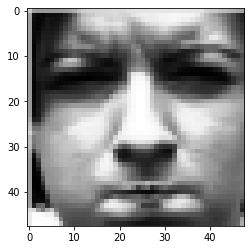

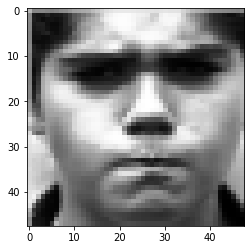

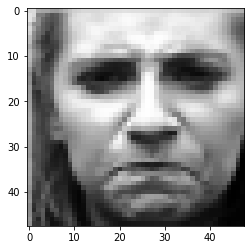

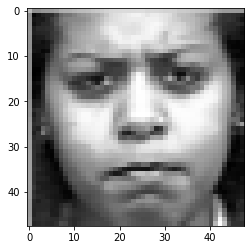

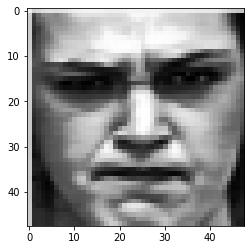

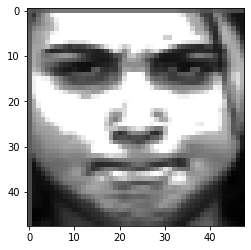

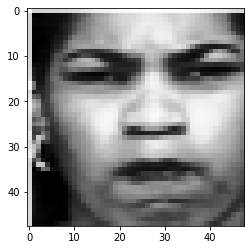

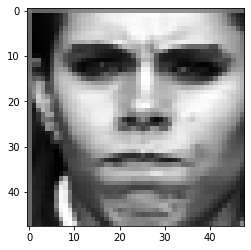

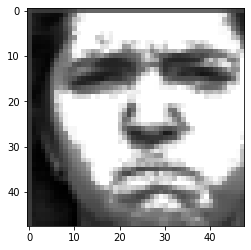

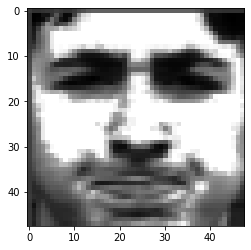

In [43]:
for i in range(10):
    img = np.array(pixels[i]).reshape(48,48)
    plt.imshow(img, cmap="gray")
    plt.show()

# Save Data

In [44]:
df.to_csv(data_path + 'ck/graylevels.csv')